### Here we will simulate the A/B tests over a new design for the webpage of an online EdTech company.

#### ***This notebook will deal with the experiment of the Click-through rate for the "home page' of the website.***

**The data contains the `timestamp` of the page visit, `user id` of the users hitting the homepage, the `group` to which the user belongs to (the 'experiment group' (those in charge of testing the "new webpage design") and the 'control group' (those in charge of testing the "old webpage design")), and the `action` ('view' if no clicks are made and 'click' if clicks are made on the home page).**

In [3]:
# Read the csv data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

home_act = pd.read_csv('./data/homepage_actions.csv')

home_act.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


#### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [9]:
# total number of actions

home_act.action.count()

8188

In [7]:
# number of unique users

len(home_act.id.unique())

6328

In [13]:
# sizes of the control and experiment groups (i.e., the number of unique users in each group)

home_act.groupby('group').nunique()

,timestamp,id,action
group,,,
control,4264,3332,2
experiment,3924,2996,2


#### 2. How long was the experiment run for? 

***Hint:*** the records in this dataset are ordered by timestamp in increasing order

In [69]:
# duration of this experiment

from datetime import datetime

duration = (datetime.strptime(home_act['timestamp'].max().split('.')[0], '%Y-%m-%d %H:%M:%S') - 
            datetime.strptime(home_act['timestamp'].min().split('.')[0], '%Y-%m-%d %H:%M:%S'))

month, day = duration.days / 30, duration.days % 30


print(f'The duration of the experiment was: {int(month)} months and {day} days.')

The duration of the experiment was: 3 months and 25 days.


#### 3. What action types are recorded in this dataset?

(i.e., What are the unique values in the action column?)

In [36]:
# action types in this experiment

home_act.action.unique(), home_act.action.value_counts()

(array(['view', 'click'], dtype=object),
 view     6328
 click    1860
 Name: action, dtype: int64)

#### 4. Why would we use `click through rate` instead of `number of clicks` to compare the performances of control and experiment pages?

***Answer:*** That is because, the number of users as a part of one group may be more than the number of users in the other group. So even if one of the groups have a greater proportion of people clicking on the page, the other group might dominate the numbers if the same group have more number of users than the former.

#### 5. Define the click through rate (CTR) for this experiment.

***Answer:*** The Click Through Rate is the proportion of the number of unique users clicking on the page to that of the number of unique users visiting the page.

$$ CTR = \frac{N\_{clickers}}{N\_{visitors}} $$

Where **$ N\_{clickers} $** is the number of users clicking on the page;
and, **$ N\_{visitors} $** is the number of users visiting the page.

#### 6. What are the null and alternative hypotheses?

***Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.***

$$ H_0 \longrightarrow CTR_{new} \leq CTR_{old} $$
$$ H_1 \longrightarrow CTR_{new} \gt CTR_{old}$$

***Or alternatively:***

$$ H_0 \longrightarrow CTR_{new} - CTR_{old} \leq 0  $$
$$ H_1 \longrightarrow CTR_{new} - CTR_{old} \gt 0 $$

#### 7. Based on the above hypotheses, figure out whether the new page should be launched or should they stick with the old page by using bootstrapping and p-value:

In [57]:
# Find the observed difference in the CTR's from the entire sample

control_df = home_act.query('group == "control"')
exp_df = home_act.query('group == "experiment"')

control_ctr = len(control_df.query('action == "click"').id.unique()) / len(control_df.query('action == "view"').id.unique())
exp_ctr = len(exp_df.query('action == "click"').id.unique()) / len(exp_df.query('action == "view"').id.unique())

obs_diff = exp_ctr - control_ctr

obs_diff

0.030034443684015644

In [62]:
# Use bootstrapping to create sampling distributions and simulate the difference over the sampling distribution

samp_diffs = []

for _ in range(10000):
    bootsamp = home_act.sample(home_act.shape[0], replace = True)
    samp_cont_df = bootsamp.query('group == "control"')
    samp_expt_df = bootsamp.query('group == "experiment"')
    samp_control_ctr = len(samp_cont_df.query('action == "click"').id.unique()) / len(samp_cont_df.query('action == "view"').id.unique())
    samp_expt_ctr = len(samp_expt_df.query('action == "click"').id.unique()) / len(samp_expt_df.query('action == "view"').id.unique())
    diffs = samp_expt_ctr - samp_control_ctr
    samp_diffs.append(diffs)
    
samp_diffs_mean = np.mean(samp_diffs)
samp_diffs_mean

0.030169160906594904

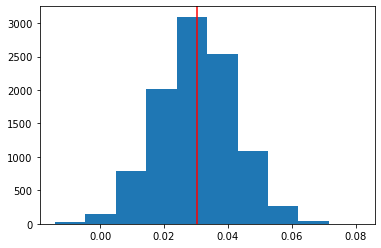

In [63]:
# Plot the samplting distribution of the difference in CTR's along with marking the mean difference in CTR's seen
# from the bootsample dataset.

plt.hist(samp_diffs);
plt.axvline(x = samp_diffs_mean, color = 'r');

In [50]:
# Observe the distribution under the 'Null' hypothesis based on a CTR diff of 0 and the spread same as that of the 
# bootstrapped diffs

null_dist = np.random.normal(0, np.std(samp_diffs), len(samp_diffs))

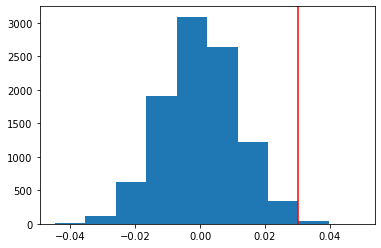

In [64]:
# Plot the null distribution with the observed CTR diff (from the whole dataset) marked on the plot.

plt.hist(null_dist);
plt.axvline(x = samp_diffs_mean, color = 'r');

***As per the above plot, we can very well see that the sampled mean diff in CTR's from the bootsample lies around the far tail of the distribution, so we can say that it is very unlikely that the statistic comes from the Null distribution or the Null Hypothesis. But we will further calculate the `p-value` to be sure....***

In [65]:
# Find the p-value to draw the conclusion

p_val = (null_dist > obs_diff).mean()
p_val

0.0052

***So, as per the p-value above, it seems to be less than the `error rate` ($ \alpha = 0.05 $), therefore we have ample evidence to reject the Null Hypothesis and confirming that the New Page is generating more CTR's or traffic than the Old Page.***